In [26]:
import torch
from torch import nn
import torch.distributions as dist
from torch.utils.data import DataLoader

torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np

In [27]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
EPS = 1e-6
DIAG = 0.1

# One dimensional - Hellinger - 2to2

### Training

In [28]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=2, num_component_output=2):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim*(self.xdim+1)/2))    # changed to take as input the parameters of the tgauss
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

    def forward(self, params):
        """ Outputs a vector [w1, w2, m1, m2, v1, v2] with w1, w2 weights summing to 1, m1, m2 means and v1, v2 variances """

        output = self.network(params)

        weights = torch.sigmoid(output[:, :self.num_component_output])
        weights = weights / weights.sum(dim=1).unsqueeze(-1)

        out_params = torch.hstack([weights, torch.exp(output[:, self.num_component_output:])])
        
        return out_params

In [4]:
network = ApproxTruncation(xdim=1, num_component_input=2, num_component_output=2)

network.forward(torch.tensor([0.5, 0.5, 10., 12., 1., 1.]).reshape(1,6))

tensor([[0.4311, 0.5689, 0.9455, 1.2378, 0.9524, 0.6783]],
       grad_fn=<CatBackward0>)

#### Generation of a dataset of truncated Gaussians

In [5]:
def generate_random_covariance(dim, lb, ub):
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub)                # strictly positive diagonal
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())                                # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    return cov_matrix


def generate_tgauss_dataset(niter, mean_bounds, sigma_bounds, ncomp, xdim):
    """ generates a list of parameters for truncated Gaussians """
    trunc_gauss = []
    for _ in range(niter):
        weights = torch.rand(ncomp)
        weights = weights / weights.sum()  # Normalize to sum to 1
        means = torch.empty(ncomp, xdim).uniform_(mean_bounds[0], mean_bounds[1])
        covariances = torch.empty(ncomp, xdim, xdim)
        for j in range(ncomp):
            covariances[j] = generate_random_covariance(xdim, sigma_bounds[0], sigma_bounds[1])
        trunc_gauss.append(torch.hstack([weights, means.flatten(), covariances.flatten()]))
    return torch.stack(trunc_gauss)

In [6]:
# half of the samples are close to zero

niter = 100_000 # number of gaussian mixtures seen during training

ncomp = 2
xdim = 1

lb1_mu = 0
ub1_mu = 1
lb1_sigma = -1
ub1_sigma = 1

trunc_gauss1 = generate_tgauss_dataset(int(0.5*niter), [lb1_mu, ub1_mu], [lb1_sigma, ub1_sigma], ncomp, xdim)

lb2_mu = 0
ub2_mu = 20
lb2_sigma = -5
ub2_sigma = 5

trunc_gauss2 = generate_tgauss_dataset(int(0.5*niter), [lb2_mu, ub2_mu], [lb2_sigma, ub2_sigma], ncomp, xdim)

trunc_gauss = torch.vstack([trunc_gauss1, trunc_gauss2])
trunc_gauss = trunc_gauss[torch.randperm(len(trunc_gauss))]

In [7]:
train_dataloader = DataLoader(trunc_gauss, batch_size=64, shuffle=True) # increased batch size, added shuffle

#### Minibatch loss function

The Hellinger distance between two distributions is $H(p, q) = 1 - \int_\mathbb{R} \sqrt{p(x)q(x)} dx $.

Now suppose $p$ is mixture of truncated Gaussians, $p = \pi_1 p_1 + \pi_2 p_2$ and $q$ is a mixture of Gaussians $q = \rho_1 q_1 + \rho_2 q_2$. Then, their Hellinger distance is

\begin{align*}
H(p, q) & = 1 - \int_\mathbb{R} \sqrt{ (\pi_1 p_1(x) + \pi_2 p_2(x))(\rho_1 q_1(x) + \rho_2 q_2(x))} dx = \\
        & = 1 - \int_\mathbb{R} \sqrt{ \pi_1\rho_1 p_1(x) q_1(x) + \pi_1\rho_2 p_1(x) q_2(x) + \pi_2\rho_1 p_2(x)q_1(x) + \pi_2\rho_2 p_2(x)q_2(x) } dx = \\
        & = 1 - \int_\mathbb{R} \sqrt{ \sum_{i,j=1}^2 \pi_i \rho_j p_i(x) q_j(x) dx }
\end{align*}

The function $\varphi(x) = -\sqrt(x)$ is convex, since is second-derivative is non-negative everywhere. Therefore Jensen's inequality holds for it, i.e. for a convex combination $\sum_i \pi_i f_i$ it holds $\varphi(\sum_i \pi_i f_i) \le \sum_i \pi_i \varphi(f_i)$. Applying this to Hellinger distance we have:

$$ H(p,q) \le 1 - \int_\mathbb{R} \sum_{i,j=1}^2 \pi_i \rho_j \sqrt{p_i q_j} dx = 1 - \sum_{i,j=1}^2 \pi_i \rho_j \int_\mathbb{R} \sqrt{p_i q_j} dx.$$

During training we minimize this upper bound

In [8]:
EPS = 10**(-10)
#import math 

def hellinger_factor(m1, s1, m2, s2):
    """ Returns $\int \sqrt(p, q)$ where p is a truncated Gaussian with mean m1 and std s1 and q is a Gaussian with mean m2 and std s2 """

    den1 = torch.sqrt(s1*s1+s2*s2)
    B = 0.5*(m1*s2*s2+m2*s1*s1)/(s1*s2*den1)
    C = m1/(s1*torch.sqrt(torch.tensor(2.)))
    D = 0.25*(-m1*m1*s2*s2-m2*m2*s1*s1+(m1*s2*s2+m2*s1*s1)**2/(s1*s1+s2*s2))/(s1*s1*s2*s2)
    den2 = torch.sqrt(1+torch.erf(C))
    den = den1*den2
    num = torch.sqrt(s1*s2)*(1+torch.erf(B))*torch.exp(D)
    L = num/den

    if L.isnan():
        print('L is nan for', m1, s1, m2, s2)
        raise
    #if L < 0 or L > 1:
      #print('io = ', m1,s1,m2,s2)
      #print(f'sqrt(s1*s2)={math.sqrt(s1*s2)}, erf(B)={torch.erf(B)}, erf(C)={torch.erf(C)}')
      #print(f'B={B}, C={C}, D={D}, den={den}, num={num}')
      #print(f'L={L}')
    #  L = torch.tensor(0.)
    
    return L


def hellinger_ub(tparams, gparams):
    """ tparams = [w1, w2, m1, m2, s1, s2] are the parameters of a mixture of two truncated gaussians
        gparams = [w1, w2, m1, m2, s1, s2] are the parameters of a mixture of two gaussians
        the function returns an upper bound on the Hellinger distance between the two mixtures"""
    
    tot = torch.tensor(1.)

    tweights = tparams[:2]
    tmeans = tparams[2:4]
    tvars = tparams[4:]

    gweights = gparams[:2]
    gmeans = gparams[2:4]
    gvars = gparams[4:]

    for i in range(2):
        for j in range(2):
            tot -= tweights[i]*gweights[j]*hellinger_factor(tmeans[i], torch.sqrt(tvars[i]), gmeans[j], torch.sqrt(gvars[j]))

    return tot

In [114]:
print(hellinger_ub(torch.tensor([0.5, 0.5, 1, 5, 0.5, 2]), torch.tensor([0.5, 0.5, 1, 5, 0.5, 2])))
print(hellinger_ub(torch.tensor([0.5, 0.5, 1, 5, 0.5, 2]), torch.tensor([0.99, 0.01, 3, 5, 2, 2])))

tensor(0.4199)
tensor(0.3184)


In [132]:
print(hellinger_ub(torch.tensor([0.5, 0.5, 110, 120, 0.5, 2]), torch.tensor([0.5, 0.5, 110, 120, 0.5, 2])))
print(hellinger_ub(torch.tensor([0.5, 0.5, 110, 120, 0.5, 2]), torch.tensor([0.99, 0.01, 115, 115, 20, 30])))

tensor(0.4997)
tensor(0.5100)


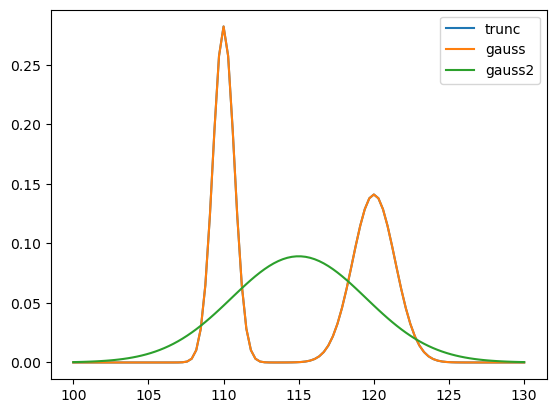

In [133]:
x = np.linspace(100,130,100)
y_trunc = plot_trunc_mixture(x, [0.5, 0.5], [110, 120], [0.5, 2])
y_gauss = plot_gauss_mixture(x, [0.5, 0.5], [110, 120], [0.5, 2])
y_gauss2 = plot_gauss_mixture(x, [0.99, 0.01], [115, 115], [20, 22])


plt.plot(x, y_trunc, label='trunc')
plt.plot(x, y_gauss, label='gauss')
plt.plot(x, y_gauss2, label='gauss2')
plt.legend()

In [12]:
def loss_function_minibatch(trunc, out_params):
    total_loss = 0
    for idx, tparams in enumerate(trunc):
        loss = 100*hellinger_ub(tparams, out_params[idx]) 
        if loss.isnan():
            print('NaN loss')
            raise
        total_loss += loss
    return (total_loss + torch.linalg.norm(out_params[:, 2:]))/len(trunc)

def train_loop_minibatch(training_dataloader, model, loss_fn, optimizer):
    
    model.train()
    counter = 0
    losses = []
    
    for bach_idx, tgauss_batch in enumerate(training_dataloader):

        out_params = model(tgauss_batch)
        if torch.any(out_params.isnan()):
            print('out params is Nan')
            raise
        
        if torch.any(out_params.isnan()):
            print('Model has generated Nan instances')
            raise
        
        loss = loss_fn(tgauss_batch, out_params)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print information
        if counter % 500 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
            losses.append(loss)
        
        if counter % 500 == 0:
            print('Generated', tgauss_batch[-1])
            print('Predicted', out_params[-1])
            
        counter += 1

    return losses


In [13]:
epochs = 1
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)              # for larger lr gives Nan

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses = train_loop_minibatch(train_dataloader, model, loss_function_minibatch, optimizer)

print("Done!")
torch.save(model, 'params/truncNNdim1-hellinger-1ep-2to2.pth')


Epoch 1
-------------------------------
loss: 59.621838
Generated tensor([ 0.4396,  0.5604, 12.3565,  5.9298,  5.1035, 12.4855])
Predicted tensor([0.5007, 0.4993, 1.1123, 1.2005, 0.8072, 0.6802],
       grad_fn=<SelectBackward0>)
loss: 32.230110
Generated tensor([3.6905e-01, 6.3095e-01, 1.6136e+01, 5.0755e+00, 9.2959e-01, 7.4181e-03])
Predicted tensor([0.7909, 0.2091, 5.3838, 4.9742, 5.0716, 4.7935],
       grad_fn=<SelectBackward0>)
loss: 27.866684
Generated tensor([0.5938, 0.4062, 0.5259, 0.0673, 0.1368, 0.5888])
Predicted tensor([0.4405, 0.5595, 0.5911, 0.5652, 0.0973, 0.0935],
       grad_fn=<SelectBackward0>)
loss: 23.388380
Generated tensor([ 0.5512,  0.4488, 13.9345,  5.8203,  6.2885,  0.9522])
Predicted tensor([0.9279, 0.0721, 6.7924, 6.8188, 6.1417, 4.3839],
       grad_fn=<SelectBackward0>)
loss: 27.334555
Generated tensor([0.4664, 0.5336, 0.0237, 0.1391, 0.0097, 0.0681])
Predicted tensor([0.0845, 0.9155, 0.2826, 0.2432, 0.0328, 0.0239],
       grad_fn=<SelectBackward0>)
los

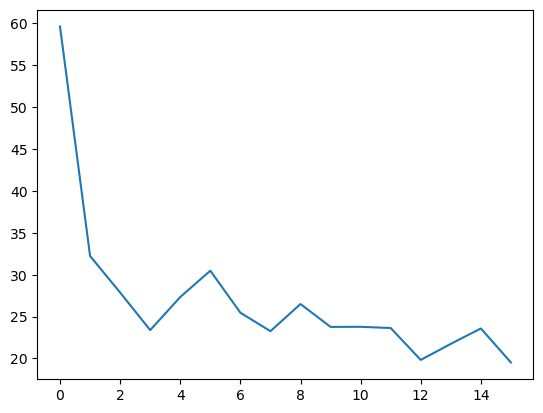

In [17]:
plt.plot(range(len(losses)), losses)

In [19]:
epochs = 10
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)              

losses = []
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses.append(train_loop_minibatch(train_dataloader, model, loss_function_minibatch, optimizer))

print("Done!")
torch.save(model, 'params/truncNNdim1-hellinger-10ep-2to2.pth')


Epoch 1
-------------------------------
loss: 57.663849
Generated tensor([ 0.5267,  0.4733,  4.3356, 14.6913,  7.3576,  0.5086])
Predicted tensor([0.4930, 0.5070, 1.1844, 0.9358, 1.0019, 1.3828],
       grad_fn=<SelectBackward0>)
loss: 52.146019
Generated tensor([0.2828, 0.7172, 0.9944, 0.7140, 0.0260, 0.5421])
Predicted tensor([0.4914, 0.5086, 1.0991, 0.9503, 0.8764, 1.2286],
       grad_fn=<SelectBackward0>)
loss: 41.698284
Generated tensor([0.4285, 0.5715, 0.2649, 0.6749, 0.0038, 0.2516])
Predicted tensor([0.4989, 0.5011, 1.0906, 0.9659, 0.8615, 1.2087],
       grad_fn=<SelectBackward0>)
loss: 48.660240
Generated tensor([0.7062, 0.2938, 6.2565, 0.4300, 0.3565, 0.5530])
Predicted tensor([0.6009, 0.3991, 1.8110, 1.6670, 1.5481, 1.9149],
       grad_fn=<SelectBackward0>)
loss: 44.353909
Generated tensor([0.8376, 0.1624, 6.6759, 4.6905, 3.6873, 0.0444])
Predicted tensor([0.6924, 0.3076, 2.9001, 2.6534, 2.6866, 2.9708],
       grad_fn=<SelectBackward0>)
loss: 42.693119
Generated tensor(

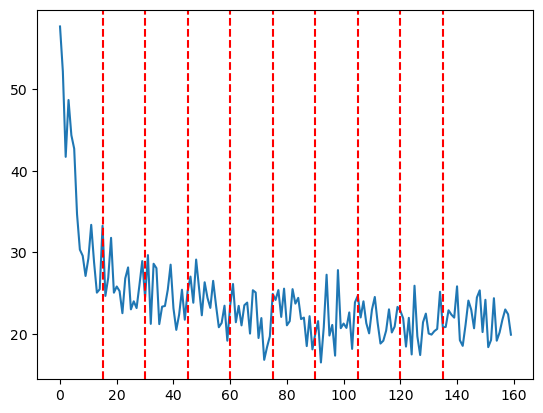

In [92]:
plot_loss = []
for loss in losses:
    plot_loss += loss

plt.plot(range(len(plot_loss)), plot_loss)
for i in range(1,10):
    plt.axvline(x=15*i, color='red', ls='--')

# Test

#### 1 Epoch

In [33]:
ncomp = 2
xdim = 1
nsamples = 100

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
model = torch.load('params/truncNNdim1-hellinger-1ep-2to2.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_29100\661473425.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-hellinger-1ep-2to2.pth

In [93]:
test_weights = []
test_means = []
test_covs = []
pred_weights = []
pred_means = []
pred_covs = []

for i in range(10):

    test_weights.append(torch.empty(ncomp).uniform_(0,1))
    test_weights[-1] = test_weights[-1] / sum(test_weights[-1])
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 5))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1][j] = generate_random_covariance(xdim, -5, 5)

    params = torch.hstack([test_weights[-1].flatten(), test_means[-1].flatten(), test_covs[-1].flatten()]).reshape(1,6)

    gparams = model(params)
    pred_weights.append(gparams.flatten()[:2].detach().numpy())
    pred_means.append(gparams.flatten()[2:4].detach().numpy())
    pred_covs.append(gparams.flatten()[4:].detach().numpy())

    print('Test params:', params)
    print('Pred params:', gparams)

Test params: tensor([[0.2898, 0.7102, 2.1345, 0.4900, 0.0280, 0.0440]])
Pred params: tensor([[9.9999e-01, 1.2041e-05, 1.1509e+00, 2.3978e-01, 1.7589e-01, 9.2900e-02]],
       grad_fn=<CatBackward0>)
Test params: tensor([[4.6887e-01, 5.3113e-01, 2.7118e+00, 4.7225e-03, 1.5849e+01, 3.8980e-02]])
Pred params: tensor([[1.0000e+00, 1.2334e-06, 9.7923e-01, 1.4869e-01, 6.1949e-01, 5.1501e-02]],
       grad_fn=<CatBackward0>)
Test params: tensor([[0.4730, 0.5270, 3.6369, 1.6366, 3.5008, 4.5456]])
Pred params: tensor([[9.9996e-01, 3.7356e-05, 3.3436e+00, 2.7533e-01, 3.1876e+00, 1.6827e-01]],
       grad_fn=<CatBackward0>)
Test params: tensor([[4.2314e-01, 5.7686e-01, 1.5510e+00, 2.3196e+00, 1.1908e-02, 1.2530e+01]])
Pred params: tensor([[1.0000e+00, 1.0597e-06, 1.8350e+00, 1.4639e-01, 1.0060e+00, 6.0290e-02]],
       grad_fn=<CatBackward0>)
Test params: tensor([[0.5598, 0.4402, 4.9600, 4.2791, 0.1644, 0.0699]])
Pred params: tensor([[1.0000e+00, 2.5513e-06, 4.4073e+00, 2.0658e-01, 7.1157e-01, 9.

In [94]:
import libSOGA

soga_weights = []
soga_means = []
soga_covs = []

for i in range(10):
    soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(list(test_weights[i]), [np.array(test_means[i][j]) for j in range(ncomp)], [np.array(test_covs[i][j]) for j in range(ncomp)]))
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

    soga_weights.append(new_soga_dist.gm.pi)
    soga_means.append(new_soga_dist.gm.mu)
    soga_covs.append(new_soga_dist.gm.sigma)

soga_weights, soga_means, soga_covs

([[0.2918395, 0.70816046],
  [0.56578773, 0.4342123],
  [0.5289469, 0.47105312],
  [0.49650657, 0.50349337],
  [0.55981773, 0.44018227],
  [0.69964874, 0.30035126],
  [0.072253324, 0.92774665],
  [0.61627597, 0.38372403],
  [0.6118235, 0.3881765],
  [0.5771845, 0.42281553]],
 [[array([2.13447118]), array([0.49553407])],
  [array([4.38628959]), array([0.15925684])],
  [array([3.75279049]), array([2.45019253])],
  [array([1.55100012]), array([3.85121539])],
  [array([4.96000099]), array([4.27910376])],
  [array([1.48445571]), array([4.7926898])],
  [array([2.81188045]), array([1.34959256])],
  [array([3.92084537]), array([2.55885748])],
  [array([3.61347229]), array([1.4808394])],
  [array([2.41984818]), array([1.80298066])]],
 [[array([[0.02795476]]), array([[0.0413023]])],
  [array([[8.50469324]]), array([[0.01436898]])],
  [array([[3.06600164]]), array([[2.5520903]])],
  [array([[0.01190773]]), array([[6.63151008]])],
  [array([[0.16440819]]), array([[0.06991072]])],
  [array([[0.7472

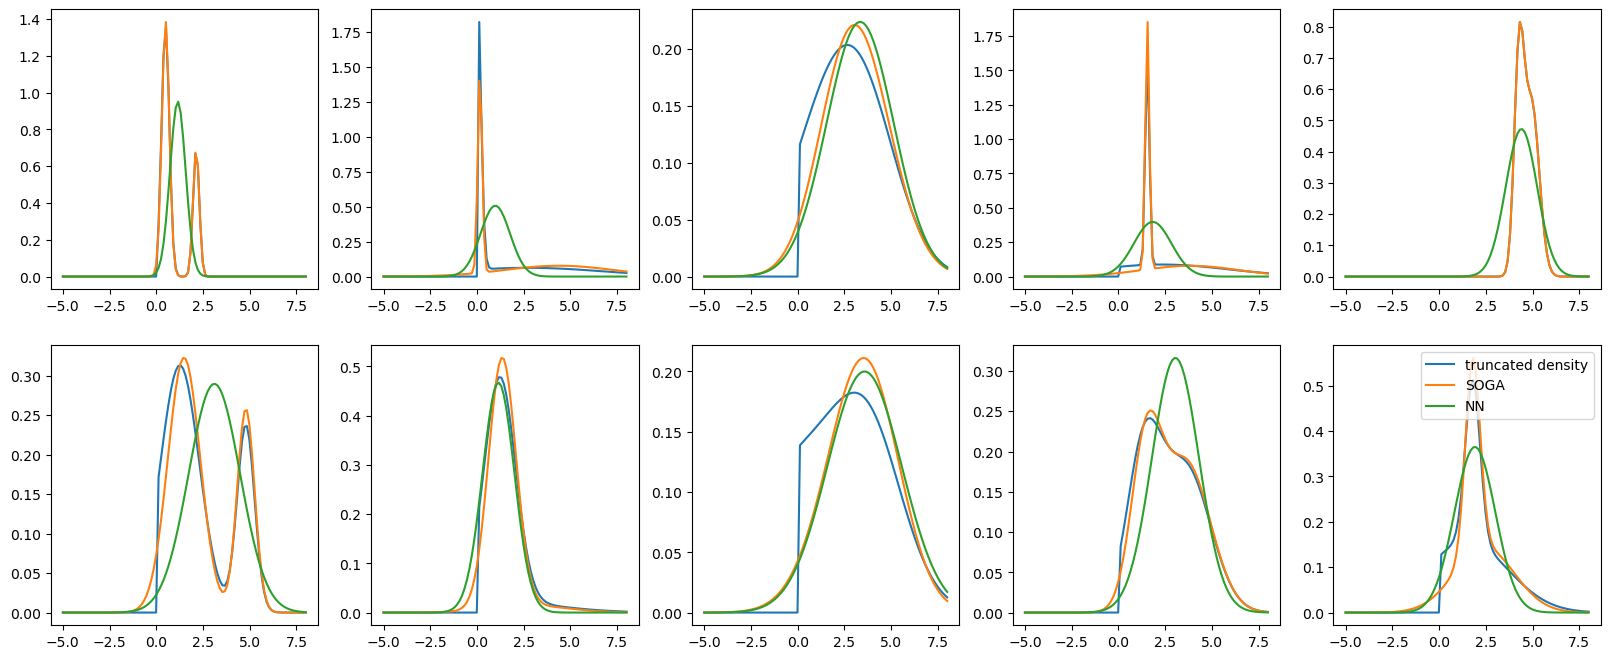

In [95]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,8,100)

def plot_trunc_mixture(x, pis, means, covs):
    y = np.zeros(len(x))
    
    for i in range(len(pis)):
        
        loc = means[i]
        scale = np.sqrt(covs[i])
        a = -loc/scale
        b = np.inf
        
        y += np.array(pis[i])*truncnorm.pdf(x, a, b, loc, scale).reshape(y.shape)

    return y

def plot_gauss_mixture(x, pis, means, covs):
    y = np.zeros(len(x))
    
    for i in range(len(pis)):
        y += np.array(pis[i])*norm.pdf(x, means[i], np.sqrt(covs[i])).reshape(y.shape)
    return y



#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    y_trunc = plot_trunc_mixture(x, test_weights[i], test_means[i], test_covs[i])
    y_soga = plot_gauss_mixture(x, soga_weights[i], soga_means[i], soga_covs[i])
    y_nn = plot_gauss_mixture(x, pred_weights[i], pred_means[i], pred_covs[i])
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()

plt.savefig('hellinger.pdf')

#### 10 Epoch

In [81]:
ncomp = 2
xdim = 1
nsamples = 100

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
model = torch.load('params/truncNNdim1-hellinger-10ep-2to2.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_29100\2358218090.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-hellinger-10ep-2to2.p

In [85]:
test_weights = []
test_means = []
test_covs = []
pred_weights = []
pred_means = []
pred_covs = []

for i in range(10):

    test_weights.append(torch.empty(ncomp).uniform_(0,1))
    test_weights[-1] = test_weights[-1] / sum(test_weights[-1])
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 5))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1][j] = generate_random_covariance(xdim, -5, 5)

    params = torch.hstack([test_weights[-1].flatten(), test_means[-1].flatten(), test_covs[-1].flatten()]).reshape(1,6)

    gparams = model(params)
    pred_weights.append(gparams.flatten()[:2].detach().numpy())
    pred_means.append(gparams.flatten()[2:4].detach().numpy())
    pred_covs.append(gparams.flatten()[4:].detach().numpy())

    print('Test params:', params)
    print('Pred params:', gparams)

Test params: tensor([[0.4930, 0.5070, 3.6112, 4.7811, 3.4290, 4.0282]])
Pred params: tensor([[9.9998e-01, 1.9512e-05, 4.1219e+00, 2.4097e-01, 2.8719e+00, 1.5070e-01]],
       grad_fn=<CatBackward0>)
Test params: tensor([[0.6164, 0.3836, 3.7198, 0.8670, 3.2832, 0.4687]])
Pred params: tensor([[9.9995e-01, 4.5343e-05, 2.9265e+00, 3.1538e-01, 1.9138e+00, 1.7912e-01]],
       grad_fn=<CatBackward0>)
Test params: tensor([[0.8518, 0.1482, 4.3310, 3.8148, 7.7550, 0.2881]])
Pred params: tensor([[9.9997e-01, 2.7594e-05, 4.4347e+00, 2.4270e-01, 3.1181e+00, 1.6469e-01]],
       grad_fn=<CatBackward0>)
Test params: tensor([[0.6442, 0.3558, 3.8775, 3.1033, 0.2894, 1.4394]])
Pred params: tensor([[9.9999e-01, 7.8949e-06, 3.5093e+00, 2.4225e-01, 9.3464e-01, 1.2105e-01]],
       grad_fn=<CatBackward0>)
Test params: tensor([[0.5676, 0.4324, 3.4452, 2.2702, 2.2363, 2.9101]])
Pred params: tensor([[9.9996e-01, 3.8861e-05, 3.1844e+00, 2.8585e-01, 2.1163e+00, 1.7154e-01]],
       grad_fn=<CatBackward0>)
Test 

In [86]:
soga_weights = []
soga_means = []
soga_covs = []

for i in range(10):
    soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(list(test_weights[i]), [np.array(test_means[i][j]) for j in range(ncomp)], [np.array(test_covs[i][j]) for j in range(ncomp)]))
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

    soga_weights.append(new_soga_dist.gm.pi)
    soga_means.append(new_soga_dist.gm.mu)
    soga_covs.append(new_soga_dist.gm.sigma)

soga_weights, soga_means, soga_covs

([[0.48868647, 0.5113135],
  [0.6370457, 0.3629543],
  [0.8438303, 0.1561697],
  [0.6453112, 0.35468876],
  [0.5884061, 0.4115939],
  [0.8924406, 0.1075594],
  [0.82190317, 0.17809688],
  [0.99824804, 0.0017519252],
  [0.49973783, 0.5002622],
  [0.4352615, 0.5647385]],
 [[array([3.72441484]), array([4.82844039])],
  [array([3.80950501]), array([1.0034831])],
  [array([4.68361154]), array([3.8147738])],
  [array([3.87748814]), array([3.12022705])],
  [array([3.487639]), array([2.57926475])],
  [array([4.34479284]), array([4.69677179])],
  [array([4.02747708]), array([3.63963389])],
  [array([4.84454473]), array([4.93721819])],
  [array([2.89526317]), array([3.25743318])],
  [array([4.96736336]), array([1.9816791])]],
 [[array([[3.00734176]]), array([[3.79980427]])],
  [array([[2.9415656]]), array([[0.33170876]])],
  [array([[6.10338153]]), array([[0.28809568]])],
  [array([[0.28942254]]), array([[1.38647179]])],
  [array([[2.08827344]]), array([[2.11297611]])],
  [array([[0.22729044]]),

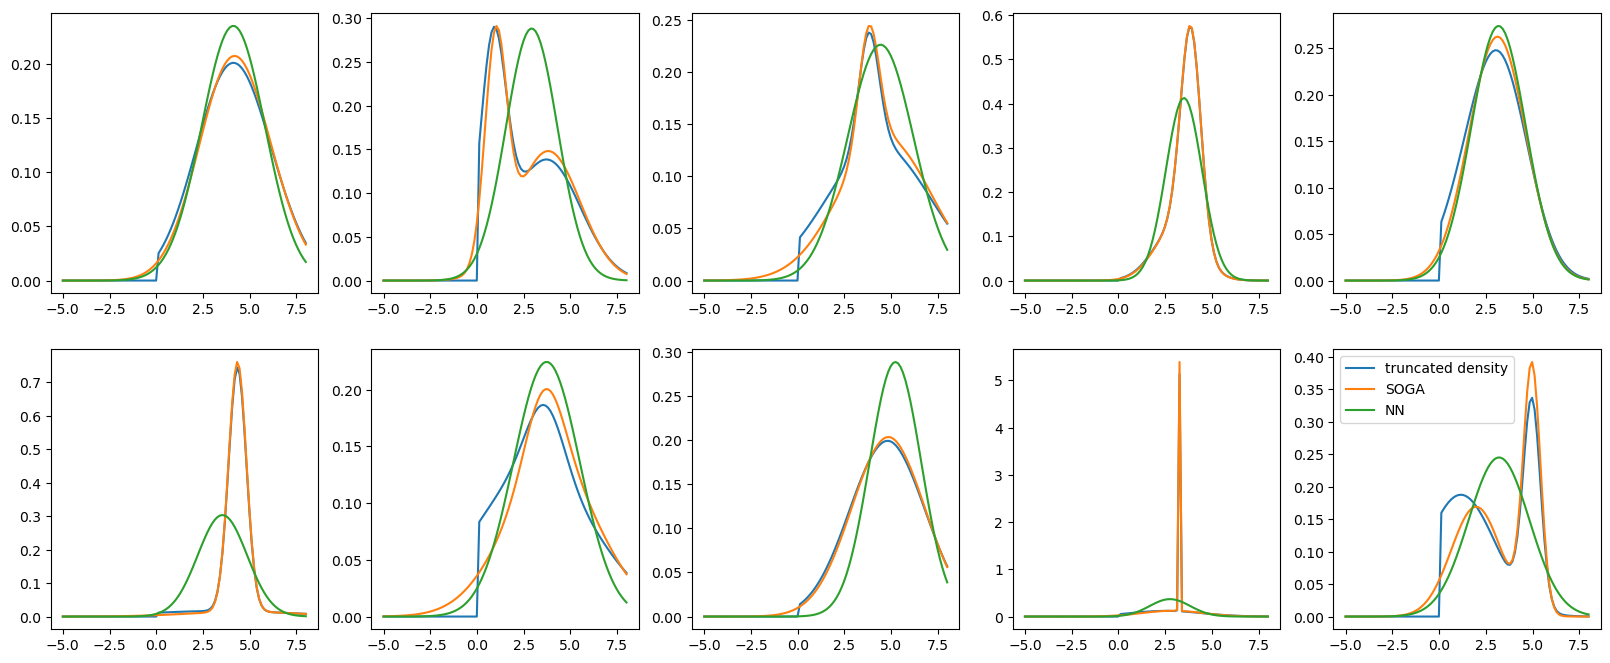

In [87]:
# Plotting
x = np.linspace(-5,8,100)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    y_trunc = plot_trunc_mixture(x, test_weights[i], test_means[i], test_covs[i])
    y_soga = plot_gauss_mixture(x, soga_weights[i], soga_means[i], soga_covs[i])
    y_nn = plot_gauss_mixture(x, pred_weights[i], pred_means[i], pred_covs[i])
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()

plt.savefig('hellinger.pdf')

### Training

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=2, num_component_output=2, nsamples=500):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.xdim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

        self.lay = nn.Linear(nsamples, 1)

    def forward(self, samples):

        output = self.network(samples)

        fl_output = self.lay(output.t())

        fl_output = fl_output.reshape((self.num_component_output,-1))

        weights = torch.sigmoid(fl_output[:, 0])
        weights = weights / weights.sum()
        mus = torch.exp(fl_output[:, 1:self.xdim+1])                                                        # put exp instead of relu
        
        if self.xdim == 1:
            covs = torch.exp(fl_output[:, self.xdim+1:].reshape((self.num_component_output, self.xdim, self.xdim)))
        else:
            # uses triangular matrices
            sigmas = torch.zeros((self.num_component_output, self.xdim, self.xdim))
            covs = torch.zeros((self.num_component_output, self.xdim, self.xdim))      
            for i in range(self.num_component_output):
                sigmas[i][np.triu_indices(self.xdim),1] = fl_output[i, self.xdim+1:-self.xdim]
                sigmas[i][np.diag_indices(self.xdim)] = torch.relu(fl_output[i, -self.xdim:]) + DIAG
                covs[i] = torch.mm(sigmas[i],sigmas[i].t()) #+ POS*torch.eye(self.xdim)

        return weights, mus, covs

In [6]:
EPS = 10**(-10)
import math 

def hellinger_distance(m1,s1,m2,s2):
    """ m1, s1 are the mean and the standard deviation of the truncated gaussian
    m2, s2 are the mean and the standard deviation of the gaussian """
    
    den1 = math.sqrt(s1*s1+s2*s2)

    B = 0.5*(m1*s2*s2+m2*s1*s1)/(s1*s2*den1+EPS)
    C = m1/(s1*math.sqrt(2)+EPS)
    D = 0.25*(-m1*m1*s2*s2-m2*m2*s1*s1+(m1*s2*s2+m2*s1*s1)**2/(s1*s1+s2*s2+EPS))/(s1*s1*s2*s2+EPS)
    den2 = math.sqrt(1+torch.erf(C))
    den = den1*den2+EPS
    num = -math.sqrt(s1*s2)*(1+torch.erf(B))*torch.exp(D)+den
    L = num/den
    if L < 0:
      print('io = ', m1,s1,m2,s2)
      print(f'sqrt(s1*s2)={math.sqrt(s1*s2)}, erf(B)={torch.erf(B)}, erf(C)={torch.erf(C)}')
      print(f'B={B}, C={C}, D={D}, den={den}, num={num}')
      print(f'L={L}')
    
    return L

In [4]:
EPS = 10**(-6)
def loss_function(samples, weights, means, covariances):

    # samples: [n_samples, xdim]
    n_samples, xdim = samples.shape

    components = weights.shape[0]

    #Generate the gaussian mixture
    distributions = [dist.MultivariateNormal(means[i], covariances[i]) for i in range(components)]
        
    log_probs = torch.zeros(samples.shape[0], components)
    
    for i in range(components):
        log_probs[:, i] = distributions[i].log_prob(samples) + torch.log(weights[i]+EPS)   

    # Log-sum-exp for numerical stability
    max_log_probs, _ = torch.max(log_probs, dim=1, keepdim=True)
    log_probs = torch.log(torch.sum(torch.exp(log_probs - max_log_probs), dim=1)) + max_log_probs.squeeze()

    #loss = torch.tensor(0.)
    #for i in range(components):
    #    loss += 0.5*torch.pow(torch.sqrt(1/covariances[i])*(samples - means[i]), 2).mean()
    #    loss -= torch.sqrt(1/covariances[i]).reshape([])
    #return loss
    
    return -log_probs.mean() #+ torch.sum(torch.pow(torch.mean(samples, dim=0) - means, 2)) + torch.sum(torch.pow(covariances, 2))

In [5]:
def generate_random_covariance(dim, lb, ub):
    #A = torch.empty(dim, dim).uniform_(lb, ub)
    
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub) #strictly positive diagonal
    
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())  # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    #cov_matrix += POS*torch.eye(dim)  # Make it positive definite

    return cov_matrix

def _truncate_samples(samples, dist):
    # Iteratively resample until all values are positive
    while torch.any(samples < 0):
        negative_indices = torch.any(samples < 0,dim=1)
        new_samples = dist.sample((negative_indices.sum(),))
        samples[negative_indices] = new_samples#[negative_indices]
    return samples

#def _truncate_samples(samples, dist):
#    # Iteratively resample until all values are positive
#    while torch.any(samples[:, 0] < 0):
#        negative_indices = torch.where(samples[:,0] < 0)[0]
#        new_samples = dist.sample((len(negative_indices),))
#        samples[negative_indices] = new_samples
#    return samples

def gm_sampling(pis, mus, sigmas, num_samples):
    
    gm_distributions = [dist.MultivariateNormal(mus[i], sigmas[i]) for i in range(len(pis))]
    
    component_choices = torch.multinomial(pis, num_samples, replacement=True)
    samples = torch.zeros(num_samples, mus.shape[1])

    for i in range(len(pis)):
        mask = (component_choices == i)
        num_samples_i = mask.sum()
        if num_samples_i > 0:
            tsamples = gm_distributions[i].sample((num_samples_i,))
            samples[mask] = _truncate_samples(tsamples, gm_distributions[i])
            #samples[mask] = gm_distributions[i].sample((num_samples_i,))
    return samples

In [6]:
# number of samples generated per gaussian mixture during training
nsamples = 100   # increased number of samples   
# number of gaussian mixtures seen during training
niter = 100000

ncomp = 1
xdim = 1

lb_mu = 0
ub_mu = 100
lb_sigma = -10
ub_sigma = 10


In [7]:
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

model.train()

losses = []
for t in range(niter):

    optimizer.zero_grad()
    weights = torch.rand(ncomp)
    weights = weights / weights.sum()  # Normalize to sum to 1
    means = torch.empty(ncomp, xdim).uniform_(lb_mu, ub_mu)
    covariances = torch.empty(ncomp, xdim, xdim)
    for j in range(ncomp):
        covariances[j] = generate_random_covariance(xdim, lb_sigma, ub_sigma)
    
    samples = gm_sampling(weights, means, covariances, nsamples)

    pi_new, mu_new, sigma_new = model(samples)

    #components = pi_new.shape[0]
    #distributions = [dist.MultivariateNormal(mu_new[i], sigma_new[i]) for i in range(components)]

    loss = loss_function(samples, pi_new, mu_new, sigma_new)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if t % 1000 == 0:
      tloss = loss.item() #batch * batch_size + len(X)
      losses.append(tloss)
      print(f"loss: {tloss:>7f} {np.round(t/niter*100,3)}%")

    if t % 10000 == 0:
        print('generated', means, covariances)
        print('predicted', mu_new, sigma_new)

print("Done!")

loss: 3582.203125 0.0%
generated tensor([[87.1233]]) tensor([[[2.1966]]])
predicted tensor([[0.7024]], grad_fn=<ExpBackward0>) tensor([[[1.0378]]], grad_fn=<ExpBackward0>)
loss: 92.573517 1.0%
loss: 36.915836 2.0%
loss: 10.170521 3.0%
loss: 6.696948 4.0%
loss: 5.725863 5.0%
loss: 5.836722 6.0%
loss: 8.479815 7.0%
loss: 7.635413 8.0%
loss: 4.091225 9.0%
loss: 8.420867 10.0%
generated tensor([[95.7505]]) tensor([[[69.9352]]])
predicted tensor([[1101.7103]], grad_fn=<ExpBackward0>) tensor([[[1962814.7500]]], grad_fn=<ExpBackward0>)
loss: 4.787001 11.0%
loss: 5.885650 12.0%
loss: 6.968954 13.0%
loss: 7.813807 14.0%
loss: 4.832395 15.0%
loss: 8.077644 16.0%
loss: 5.571854 17.0%
loss: 5.526316 18.0%
loss: 4.559655 19.0%
loss: 3.611260 20.0%
generated tensor([[12.5172]]) tensor([[[16.5493]]])
predicted tensor([[9.1268]], grad_fn=<ExpBackward0>) tensor([[[10.8475]]], grad_fn=<ExpBackward0>)
loss: 2.516474 21.0%
loss: 3.690588 22.0%
loss: 3.858294 23.0%
loss: 3.554418 24.0%
loss: 4.383433 25.0%

In [42]:
torch.save(model, 'params/truncNNdim1-direct-1to1.pth')

In [43]:
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.title('loss')
plt.xlabel('iterations')
plt.ylim(0,100)
plt.show()

NameError: name 'losses' is not defined

<Figure size 640x480 with 0 Axes>

### Test

In [47]:
ncomp = 1
xdim = 1
nsamples = 100

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
model = torch.load('params/truncNNdim1-direct-1to1.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_27912\3689444106.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-direct-1to1.pth')


In [48]:
test_weights = torch.rand(ncomp)
test_weights = test_weights / test_weights.sum()  # Normalize to sum to 1
test_means = torch.empty(ncomp, xdim).uniform_(0, 10)
test_covariances = torch.empty(ncomp, xdim, xdim)

for j in range(ncomp):
  test_covariances[j] = generate_random_covariance(xdim, -5, 5)

test_samples = gm_sampling(test_weights, test_means, test_covariances, nsamples)

pi_pred, mu_pred, sigma_pred = model(test_samples)

print('Test params:', test_weights, test_means, test_covariances)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: tensor([1.]) tensor([[7.4222]]) tensor([[[1.1471]]])
Pred params: tensor([1.], grad_fn=<DivBackward0>) tensor([[9.6497]], grad_fn=<ExpBackward0>) tensor([[[16.0369]]], grad_fn=<ExpBackward0>)


In [49]:
import libSOGA

soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[0])], [np.array(test_covariances[0])]))
_, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

soga_w = new_soga_dist.gm.pi[0]
soga_mean = new_soga_dist.gm.mu[0]
soga_cov = new_soga_dist.gm.sigma[0]

soga_w, soga_mean, soga_cov

(1.0, array([7.42216206]), array([[1.1470933]]))

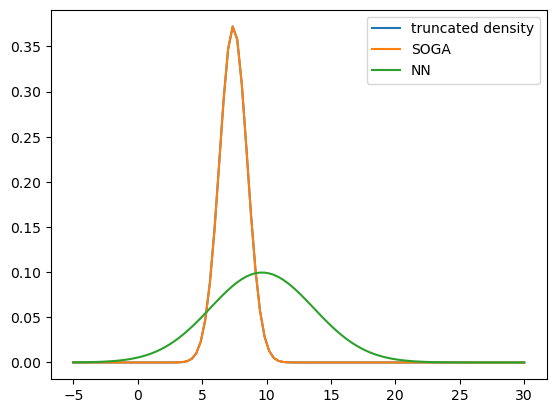

In [50]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,30,100)

loc = test_means[0]
scale = np.sqrt(test_covariances[0])
a = -loc/scale
b = np.inf

y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
y_soga = norm.pdf(x, soga_mean, np.sqrt(soga_cov)).reshape(x.shape)
y_nn = norm.pdf(x, mu_pred.detach().numpy(), np.sqrt(sigma_pred.detach().numpy())).reshape(x.shape)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.plot(x, y_trunc, label='truncated density')
plt.plot(x, y_soga, label='SOGA')
plt.plot(x, y_nn, label='NN')

plt.legend()

Dobbiamo usare la direct KL invece della reverse (la likelihood e' equivalente alla reverse).

Sia $q$ la distribuzione usata per la stima e $p$ la troncata che vogliamo approssimare.

$$ KL(q || p) = \mathbb{E}_q\big[\log\big(\frac{q}{p}\big)\big] = H(q) - \mathbb{E}_q[\log(p)] = H(q) - \int_{\mathbb{R}^2} q(s) \log(p(s)) dx $$

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=1, num_component_output=1):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim**2)) 
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

    def forward(self, params):

        output = self.network(params)
        
        weights = torch.sigmoid(output[:self.num_component_output])
        weights = weights / weights.sum()
        mus = torch.exp(output[self.num_component_output:self.num_component_output*(self.xdim+1)]).reshape((self.num_component_output, self.xdim))                                                       

        if self.xdim == 1:
            covs = torch.exp(output[self.num_component_output*(self.xdim+1):]).reshape((self.num_component_output, 1))
        else:
            # uses triangular matrices
            sigmas = torch.zeros((self.num_component_output, self.xdim, self.xdim))
            covs = torch.zeros((self.num_component_output, self.xdim, self.xdim))      
            for i in range(self.num_component_output):
                sigmas[i][np.triu_indices(self.xdim),1] = fl_output[i, self.xdim+1:-self.xdim]
                sigmas[i][np.diag_indices(self.xdim)] = torch.relu(fl_output[i, -self.xdim:]) + DIAG
                covs[i] = torch.mm(sigmas[i],sigmas[i].t()) #+ POS*torch.eye(self.xdim)

        return weights, mus, covs

In [ ]:
GRID = torch.linspace(EPS, 10, 100)
delta = GRID[1] - GRID[0]
nsamples = 500

from botorch.utils.probability.truncated_multivariate_normal import TruncatedMultivariateNormal as TruncNorm

def loss_function(params, weights, means, covariances):

    ncomp = weights.shape[0]
    xdim = means[0].shape[0]

    w_trunc = params[:ncomp]
    mu_trunc = params[ncomp:ncomp*(xdim+1)].reshape(ncomp,xdim)
    cov_trunc = params[ncomp*(xdim+1):].reshape(ncomp,xdim,xdim)

    if xdim == 1 & ncomp == 1:
        norm = dist.Normal(means[0], covariances[0])          # Normal distribution (the one we are estimating)
        tnorm = dist.Normal(mu_trunc, torch.sqrt(cov_trunc))  # Truncated normal (the one we want to approximate)
        norm_factor = 1 - tnorm.cdf(torch.tensor(0.))         # Normalization factor for truncated normal
        loss = norm.entropy() - delta*torch.sum(torch.exp(norm.log_prob(GRID))*(tnorm.log_prob(GRID)-torch.log(norm_factor)))

        #norm = dist.Normal(means[0], covariances[0])          # Normal distribution (the one we are estimating)
        #samples = norm.sample((nsamples,1))                   # generates samples from normal
        #positive_indices = torch.any(samples > 0, dim=1)      # negative samples have likelihood 0
        #tnorm = dist.Normal(mu_trunc, torch.sqrt(cov_trunc))  # Truncated normal (the one we want to approximate)
        #norm_factor = 1 - tnorm.cdf(torch.tensor(0.))         # Normalization factor for truncated normal 
        #loss = norm.entropy() - torch.mean(tnorm.log_prob(samples[positive_indices])-torch.log(norm_factor))
        return loss
    

### Training

In [12]:
# number of gaussian mixtures seen during training
niter = 50000

ncomp = 1
xdim = 1

lb_mu = 0
ub_mu = 10
lb_sigma = -5
ub_sigma = 5

# changed the bounds
#bounds_mu = [lb_mu*torch.ones(xdim),ub_mu*torch.ones(xdim)]
#bounds_sigma = [lb_sigma**torch.ones(xdim**2), ub_sigma**torch.ones(xdim**2)] 


In [13]:
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

model.train()

losses = []
for t in range(niter):

    optimizer.zero_grad()
    weights = torch.rand(ncomp)
    weights = weights / weights.sum()  # Normalize to sum to 1
    means = torch.empty(ncomp, xdim).uniform_(lb_mu, ub_mu)
    covariances = torch.empty(ncomp, xdim, xdim)
    for j in range(ncomp):
        if xdim == 1:
            covariances[j] = torch.empty(1).uniform_(EPS, ub_sigma)
        else:
            covariances[j] = generate_random_covariance(xdim, lb_sigma, ub_sigma)
    
    params = torch.hstack((weights, means.flatten(), covariances.flatten()))
    pi_new, mu_new, sigma_new = model(params)
    
    loss = loss_function(params, pi_new, mu_new, sigma_new)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if t % 1000 == 0:
      tloss = loss.item() #batch * batch_size + len(X)
      losses.append(tloss)
      print(f"loss: {tloss:>7f} {np.round(t/niter*100,3)}%")

    if t % 10000 == 0:
        print('generated', means, covariances)
        print('predicted', mu_new, sigma_new)

print("Done!")

loss: 2.741231 0.0%
generated tensor([[1.3681]]) tensor([[[1.3533]]])
predicted tensor([[1.0909]], grad_fn=<ViewBackward0>) tensor([[1.0990]], grad_fn=<ViewBackward0>)
loss: 10.331261 2.0%
loss: 2.691677 4.0%
loss: 2.772292 6.0%
loss: 15.476457 8.0%
loss: 2.687554 10.0%
loss: 2.800953 12.0%
loss: 4.126326 14.0%
loss: 48.653835 16.0%
loss: 4.081121 18.0%
loss: 3.544315 20.0%
generated tensor([[3.3290]]) tensor([[[2.5634]]])
predicted tensor([[1.0421]], grad_fn=<ViewBackward0>) tensor([[0.8220]], grad_fn=<ViewBackward0>)
loss: 3.200329 22.0%
loss: 3.167950 24.0%
loss: 2.387177 26.0%
loss: 27.369284 28.0%
loss: 8.335875 30.0%
loss: 5.456818 32.0%
loss: 3.585928 34.0%
loss: 6.797420 36.0%
loss: 243.549500 38.0%
loss: 14.045031 40.0%
generated tensor([[8.2481]]) tensor([[[2.1486]]])
predicted tensor([[0.8760]], grad_fn=<ViewBackward0>) tensor([[0.2544]], grad_fn=<ViewBackward0>)
loss: 2.110219 42.0%
loss: 2.849788 44.0%
loss: 2.101459 46.0%
loss: 7.804923 48.0%
loss: 5.091722 50.0%
loss: 1.

In [13]:
torch.save(model, 'params/truncNNdim1-1to1.pth')

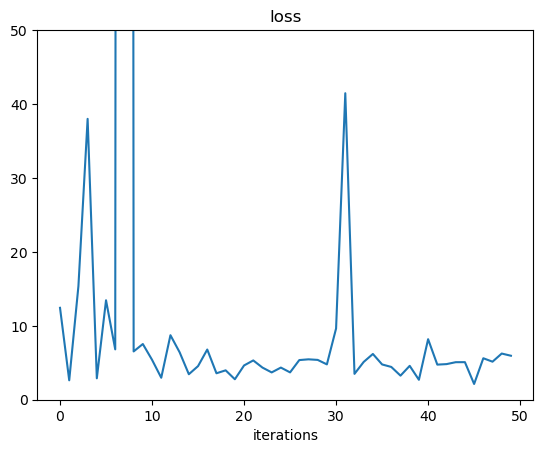

In [17]:
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.title('loss')
plt.xlabel('iterations')
plt.ylim(0,50)
plt.show()

### Test

In [85]:
ncomp = 1
xdim = 1

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
model = torch.load('params/truncNNdim1-1to1.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_20568\2786245131.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-1to1.pth')


In [90]:
test_weights = torch.rand(ncomp)
test_weights = test_weights / test_weights.sum()  # Normalize to sum to 1
test_means = torch.empty(ncomp, xdim).uniform_(0, 10)
test_covariances = torch.empty(ncomp, xdim, xdim).uniform_(EPS, 5)

test_params = torch.hstack((test_weights, test_means.flatten(), test_covariances.flatten()))

pi_pred, mu_pred, sigma_pred = model(test_params)

print('Test params:', test_weights, test_means, test_covariances)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: tensor([1.]) tensor([[6.1747]]) tensor([[[0.8025]]])
Pred params: tensor([1.], grad_fn=<DivBackward0>) tensor([[18.9858]], grad_fn=<ViewBackward0>) tensor([[2.0688e-05]], grad_fn=<ViewBackward0>)


In [91]:
import libSOGA

soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[0])], [np.array(test_covariances[0])]))
_, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

soga_w = new_soga_dist.gm.pi[0]
soga_mean = new_soga_dist.gm.mu[0]
soga_cov = new_soga_dist.gm.sigma[0]

soga_w, soga_mean, soga_cov

(1.0, array([6.17472601]), array([[0.8024537]]))

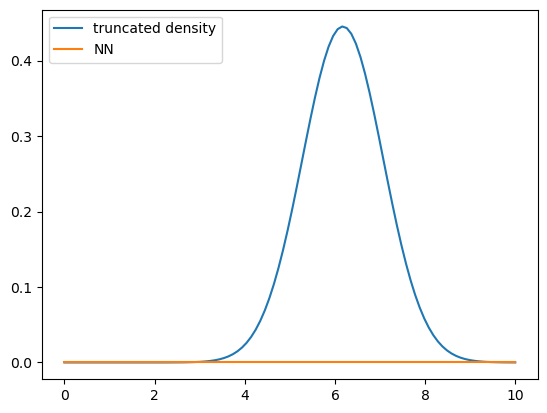

In [92]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = GRID.numpy()

loc = test_means[0]
scale = np.sqrt(test_covariances[0])
a = -loc/scale
b = np.inf

y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
y_soga = norm.pdf(x, soga_mean, np.sqrt(soga_cov)).reshape(x.shape)
y_nn = norm.pdf(x, mu_pred.detach().numpy(), np.sqrt(sigma_pred.detach().numpy())).reshape(x.shape)

plt.plot(x, y_trunc, label='truncated density')
#plt.plot(x, y_soga, label='SOGA')
plt.plot(x, y_nn, label='NN')

plt.legend()